In [1]:
import yfinance as yf
import pandas as pd
import datetime as dt

In [2]:
## 輸入股票代碼
stock_id = "2330.tw"
taiwan_2330_stock = yf.Ticker(stock_id)

## 設定時間範圍(抓取一年資料)
data = taiwan_2330_stock.history(period="1y")


In [3]:
# 選擇收盤價作為預測目標
close_prices = data['Close']

# 採分資料分為訓練即(70%) 和測試其(30%)  #多思，可以看到這裡就只有一個欄位而已耶。
train_size = int(len(close_prices) * 0.7)
train , test = close_prices[: train_size], close_prices[train_size: ]

print(f"訓練集長度: {len(train)}")
print(f"測試集長度: {len(test)}")


訓練集長度: 170
測試集長度: 73


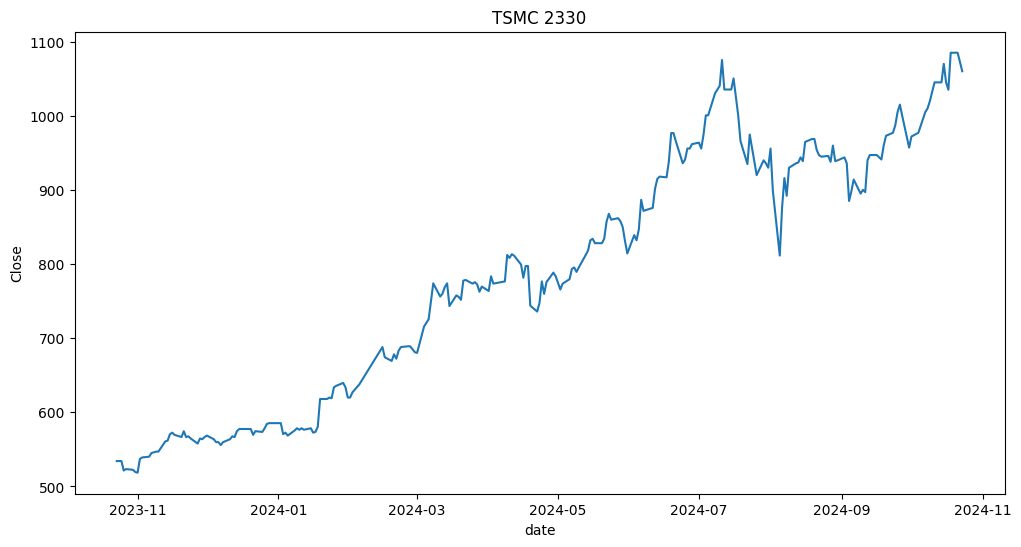

In [4]:
## 股票走勢視覺話
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(close_prices)
plt.title('TSMC 2330')
plt.xlabel('date')
plt.ylabel('Close')
plt.show()

In [5]:
### ======== #####
'''
ADF 檢查-檢查平穩度
如果 p-value < 0.05， 則數據是平穩的; 否則，需要進行差分處理。
'''

from statsmodels.tsa.stattools import adfuller
result = adfuller(close_prices)
print('ADF 統計量: ', result[0]) # -0.5953083721461891
print('p-value: ', result[1])   ## 0.8720386223497135  ## 我需要進行平滑話處理。

close_price_diff = close_prices.diff().dropna()

ADF 統計量:  -0.5953078318995264
p-value:  0.8720387436130198


In [6]:
# 再次進行 ADF 檢定
result_2 = adfuller(close_price_diff )
print('ADF 統計量: ', result_2[0]) # -0.5953083721461891

## 太小了， 我要處理比較好看
formatted_number = f"{result_2[1]:.10f}"
print('p-value: ', formatted_number)   ## 0.0000000000 .....


ADF 統計量:  -9.036694300853362
p-value:  0.0000000000


'''
使用 ARIMA 模型參數的回圈尋找最佳參數(p, d, q)組合。
這裡設計了一個optimize- arima 函數，
根據不同的p, d, q 值來測試 和優化模型。
p, d ,q 代表的意識是
P 為 自迴歸向數。
d 為 差分階數。
q 為 移動平均項數。
'''

In [7]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

In [8]:
def optimize_arima(train_data , p_value, d_value, q_value):
    best_score, best_cfg = float("inf"), None
    best_model = None

    ## 這個視乎要在去切分，才能做訓練呀。
    train_size = int(len(train_data) * 0.8)  # 80% 訓練 20% 測試
    train_this , test_this = train_data[0: train_size], train_data[train_size: ]

    # 使用回歸迭代 p, d, q 組合找出最佳參數  ## 這個算是窮舉了拉。
    for p in p_value:
        for d in d_value:
            for q in q_value:
                ## 為什麼這邊還要做例外條件的處理呀?!
                try:
                    model = ARIMA(train_this, order=(p,d,q))
                    model_fit = model.fit()
                    yhat = model_fit.forecast(steps=len(test_this))  ## 這個 test 是什麼意思??
                    error = mean_squared_error(test_this, yhat)
                    if error < best_score:
                        best_score, best_cfg = error, (p, d, q)
                        best_model = model_fit
                except:
                    print(f"Error for (p, d, q)=({p}, {d}, {q})")
                    continue
    return best_cfg, best_model


In [9]:
## 定義 p, d, q 參數範圍
p_values = range(0, 6) ## 範圍 0 ~ 5
d_values = range(0, 3) ## 範圍 0 ~ 2
q_values = range(0, 6) ## 範圍 0 ~ 5

## 找出ARIMA 模型最佳參數
best_cfg, best_model = optimize_arima(train, p_values, d_values, q_values)

## 印出最佳參數
print(f' 最佳參數 {best_cfg}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 最佳參數 (3, 2, 5)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [10]:
## 預測
yhat = best_model.forecast(steps=len(test))

## 計算RMSE 誤差
from math import sqrt
rmse_optimized = sqrt(mean_squared_error(test, yhat))

## 印出誤差RMSE
print(f"RMSE: {rmse_optimized}")


RMSE: 84.48625601245475


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


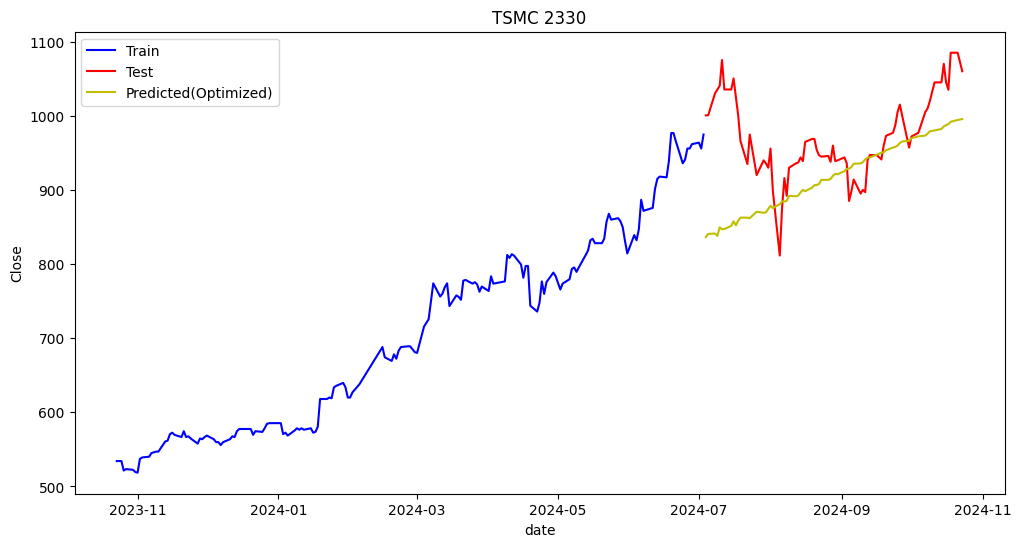

In [11]:
yhat.index = test.index

plt.figure(figsize=(12,6))
plt.plot(train,'b',label='Train')
plt.plot(test, 'r',label='Test')
plt.plot(yhat,'y',label='Predicted(Optimized)')
plt.title('TSMC 2330')
plt.xlabel('date')
plt.ylabel('Close')
plt.legend()
plt.show()